## 1-D Transiet heat diffusion solver with Physics Informed Neural Networks 

**Import the libraries**

In [1]:
## Import basic numerical and plotting packages ##
from utils.importer import *

## Import the numerical PDE solver ##
from utils.numericalSolver import NumPDE

# ## Import the neural network dataprocessor and framework ##
from utils.PINN import DataPreprocessor, PINN

**Setup the calculation details**

The governing equation is by, 

$$\frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}$$  

The domain and time range is defined as follows, 

$$\forall \, x \in (0,l) \text{ and } 0 < t < t_{range}$$

Initial conditions are as follows,

$$T(x, 0) = 0 $$

Boundary conditions are defined as,

$$ \left.\frac{\partial T}{\partial x}\right\vert_{(0,t)} = 0 \text{ and } \left. T \right\vert_{(l,t)} = sin(t)$$

In [2]:
## total time of simulation and length of the system ##
trange, l = 2*np.pi, 1

## Package the time and spatial domain ##
extent = [[0, l], [0, trange]]

## Specify time and space discretizations ##
nx, nt = 256, 100

## Specify how much of available training data will be randomly picked for training in the domain, IC and BCs##
frac = {'ic': 0.8, 'bc': 0.8, 'dom' : 0.0}

## Specify the number of random points in the domain to evaluate PDE loss
N_f = 10000

## Neural Network structure ##
    ## Two inputs (x and t) and one output (temperature)
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

## Initialize the 1-D grid for the numerical solver ##
grid = CartesianGrid([[0, l]], nx)  

## Setup the initial condition of the system ##
    ## For the current problem it is set at 0 ##
field = ScalarField(grid, 0)        

## Definition of the diffusion PDE ##
    ## Specify diffusivity of the domain ##
diffusivity = 0.1
    ## Define the rhs of differential equation ##
rhs = f"(({diffusivity}) * laplace(c))"
    ## Specify the boundary conditions, first left end and then right end ##
bc = [[{'derivative':0}, {'value_expression':'sin(t)'}]]
    ## package thegoverning equation and boundary conditions ##
eq = PDE({"c": f"{rhs}"}, bc=bc)

**Obtain the numerical solution**

In [3]:
## Obtain the numerical solution ##
    ## We use explicit RK-4 adaptive time stepping ##
    ## Also specified the time discretization  using the variable nt ##
if os.path.isfile('saved/numSol.pkl'):
    with open('saved/numSol.pkl', 'rb') as file:
        numSol = pkl.load(file)
else:
    numSol = NumPDE(eq, grid, field, 'Explicit', trange, trange/nt).ground_truth

**Create the NN data from numerical solution**

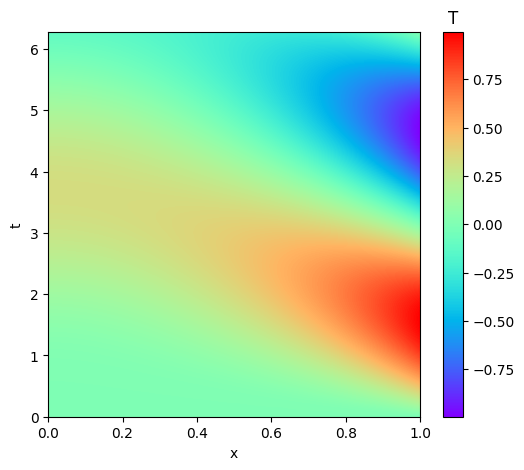

In [4]:
NNdata = DataPreprocessor(numSol, frac, extent, N_f)

**Setup the NN, train and save the weights**

In [ ]:
from utils.importer import *

class DataPreprocessor():

    def __init__(self, 
                 sol: dict,
                 frac: dict,
                 extent: np.ndarray,
                 N_f: int):
        
        ## Store the domain dimensions ##
        self.extent = extent

        ## Dictionary to store numerical solution data ##
        self.sol = sol
        
        ## Generate ground truth
        self.create_ground_truth()        
        
        ## Randomly pick data points for the training datasets ##
        self.traindata = {}
        self.create_train_dataset(frac, N_f)
        
        ## Save figure ##        
        self.fig.savefig('results/ground_truth.png')
        
    ## Function to create the ground truth over the domain from the numerical solver data
    def create_ground_truth(self):

        ## Exctract the data
        t = self.sol['t'].flatten()[:,None]
        x = self.sol['x'].flatten()[:,None]
        u = np.real(self.sol['u'])

        ## Create grid
        X, T = np.meshgrid(x,t)

        ## Compile the flattened grid and function values
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]

        ## Store the data
        self.ground_truth = {'inp': inp,
                             'out': out}
        
        ## Plot the ground truth
        fig, ax = plt.subplots(figsize=(6,5))
        im = ax.imshow(self.sol['u'], origin='lower', aspect='auto',
                       extent=np.asarray(self.extent).flatten(),
                       interpolation='bilinear', cmap='rainbow')
        clb = fig.colorbar(im, ax=ax, location='right')
        clb.ax.set_title('T')
        ax.set_xlabel('x')
        ax.set_ylabel('t')

        ## Save the figure object
        self.ax = ax
        self.fig = fig

    ## Function to create dataset out of provided grid and function values
    def create_train_dataset(self, frac, N_f):
        
        ## Extract the exact solution ##
        data = self.sol
        t = data['t'].flatten()[:,None]
        x = data['x'].flatten()[:,None]
        u = np.real(data['u'])        
        
        ## Specify the number of points for boundaries ##
        N_ic = int(x.shape[0]*frac['ic'])
        N_bc = int(t.shape[0]*frac['bc'])
        N_d = int(u[1:,1:-1].shape[0]*frac['dom'])*int(u[1:,1:-1].shape[1]*frac['dom'])
        
        ## Create grid ##
        X, T = np.meshgrid(x,t)
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]     
        
        
        ## Start picking random points ##
            ## from initial condition
        train_ic = {}
        inp_ic = np.hstack((X[:1,:].T, T[:1,:].T))
        out_ic = u[:1,:].T
        idx_ic = np.random.choice(inp_ic.shape[0], N_ic, replace=False)
        train_ic.update({'inp': inp_ic[idx_ic, :], 
                         'out': out_ic[idx_ic, :]})
#         self.ax.scatter(train_ic['inp'][:,0], train_ic['inp'][:,1], marker='x',
#                         c = 'k', s=15, clip_on=False, alpha=0.8,
#                         linewidth=1)
            ## from left boundary condition
        train_bcl = {}
        inp_bcl = np.hstack((X[:,:1], T[:,:1]))
        out_bcl = u[:,:1]
        idx_bcl = np.random.choice(inp_bcl.shape[0], N_bc, replace=False)
        train_bcl.update({'inp': inp_bcl[idx_bcl, :], 
                          'out': out_bcl[idx_bcl, :]})  
#         self.ax.scatter(train_bcl['inp'][:,0], train_bcl['inp'][:,1], marker='x',
#                         c = 'k', s=15, clip_on=False, alpha=0.8,
#                         linewidth=1)
            ## from right boundary condition
        train_bcr = {}
        inp_bcr = np.hstack((X[:,-1:], T[:,-1:]))
        out_bcr = u[:,-1:]
        idx_bcr = np.random.choice(inp_bcr.shape[0], N_bc, replace=False)
        train_bcr.update({'inp': inp_bcr[idx_bcr, :], 
                          'out': out_bcr[idx_bcr, :]})    
#         self.ax.scatter(train_bcr['inp'][:,0], train_bcr['inp'][:,1], marker='x',
#                         c = 'k', s=15, clip_on=False, alpha=0.8,
#                         linewidth=1)
            ## from the domain
        train_dom = {}
        inp_dom = np.hstack((X[1:,1:-1].flatten()[:, None],
                             T[1:,1:-1].flatten()[:, None]))
        out_dom = u[1:,1:-1].flatten()[:,None]
        idx_dom = np.random.choice(inp_dom.shape[0], N_d, replace=False)
        train_dom.update({'inp': inp_dom[idx_dom, :], 
                          'out': out_dom[idx_dom, :]})
#         self.ax.scatter(train_dom['inp'][:,0], train_dom['inp'][:,1], marker='.',
#                         c = 'k', s=15, clip_on=False, alpha=0.5, linewidth=1)
            ## from the PDE
        train_pde = {}
        lb = inp.min(0)
        ub = inp.max(0) 
        inp_pde = lb + (ub-lb)*lhs(2, N_f)
        train_pde.update({'inp': inp_pde})
#         self.ax.scatter(train_pde['inp'][:,0], train_pde['inp'][:,1], marker='+',
#                         c = 'k', s=15, clip_on=False, alpha=0.8, linewidth=1)
            ## Package all the dictionaries into traindata
        self.traindata.update({'ic': train_ic, 'bcl': train_bcl, 
                               'bcr': train_bcr, 'dom': train_dom,
                               'pde': train_pde})

# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class PINN():
    def __init__(self, data, layers, diffusivity, maxepochs, early_stop_threshold):

        ## gather train data ##
            ## Initial Condition ##
        self.xtrain_ic = torch.tensor(data.traindata['ic']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_ic = torch.tensor(data.traindata['ic']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_ic = torch.tensor(data.traindata['ic']['out']).float().to(device)        
            ## Boundary Condition Left ##
        self.xtrain_bcl = torch.tensor(data.traindata['bcl']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_bcl = torch.tensor(data.traindata['bcl']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_bcl = torch.tensor(data.traindata['bcl']['out']).float().to(device)   
            ## Boundary Condition Right ##
        self.xtrain_bcr = torch.tensor(data.traindata['bcr']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_bcr = torch.tensor(data.traindata['bcr']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_bcr = torch.tensor(data.traindata['bcr']['out']).float().to(device)   
            ## Domain data ##
        self.xtrain_dom = torch.tensor(data.traindata['dom']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_dom = torch.tensor(data.traindata['dom']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_dom = torch.tensor(data.traindata['dom']['out']).float().to(device)           
            ## PDE loss collocation points ##
        self.xtrain_pde = torch.tensor(data.traindata['pde']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_pde = torch.tensor(data.traindata['pde']['inp'][:, 1:2], requires_grad=True).float().to(device)

        ## gather test data
        self.xtest = torch.tensor(data.ground_truth['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttest = torch.tensor(data.ground_truth['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utest = torch.tensor(data.ground_truth['out']).float().to(device)

        ## Assign layers
        self.layers = layers
        
        ## diffusivity ##
        self.diffusivity = diffusivity

        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        ## Set the number of max epochs
        self.maxepochs = maxepochs
        
        ## Set the early stop criteria ##
        self.early_stop_threshold = early_stop_threshold

        # optimizers: using the same settings
        self.optimizer = torch.optim.Adam(self.dnn.parameters())
    
        ## Initiate the storage for losses ##
        self.iter = 0
        self.losses = {'train': [],
                       'train_ic': [],
                       'train_bcl': [],
                       'train_bcr': [],
                       'train_dom': [],
                       'train_pde': [],                       
                       'test': [],
                       'iter': []}

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_dudx(self, x, t):
        
        u = self.net_u(x, t)
        dudx = torch.autograd.grad(u, x, 
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0]
        return dudx
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        dudt = torch.autograd.grad(u, t,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0]        
        dudx = torch.autograd.grad(u, x,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0]
        ddudxx = torch.autograd.grad(dudx, x, 
                                     grad_outputs=torch.ones_like(dudx),
                                     retain_graph=True,
                                     create_graph=True)[0]
        f = dudt - self.diffusivity * ddudxx
        return f
    
    def loss_func(self):

        ## Training Losses ##
            ## Initial condition ##
        uhat_ic = self.net_u(self.xtrain_ic, self.ttrain_ic)
        loss_ic = torch.mean((self.utrain_ic - uhat_ic) ** 2)
            ## Boundary condition left ##
        dudxhat_bcl = self.net_dudx(self.xtrain_bcl, self.ttrain_bcl)
        loss_bcl = torch.mean((dudxhat_bcl) ** 2)
            ## Boundary condition right ##
        uhat_bcr = self.net_u(self.xtrain_bcr, self.ttrain_bcr)
        loss_bcr = torch.mean((self.utrain_bcr - uhat_bcr) ** 2)        
            ## Data on the domain ##
        if self.xtrain_dom.shape[0] == 0:
            loss_dom = torch.tensor(0).float().to(device)
        else:
            uhat_dom = self.net_u(self.xtrain_dom, self.ttrain_dom)
            loss_dom = torch.mean((self.utrain_dom - uhat_dom) ** 2)
            ## PDE loss on the collocation points ##
        if self.xtrain_pde.shape[0] == 0:
            loss_pde = torch.tensor(0).float().to(device)
        else:
            pde_val = self.net_f(self.xtrain_pde, self.ttrain_pde)
            loss_pde = torch.mean(pde_val ** 2)
            ## Final loss ##
        loss_train = loss_ic + loss_bcl + loss_bcr + loss_pde + loss_dom

        ## Save the losses ##
        self.iter += 1
        self.losses['train'].append(loss_train.item())
        self.losses['train_ic'].append(loss_ic.item())
        self.losses['train_bcl'].append(loss_bcl.item())
        self.losses['train_bcr'].append(loss_bcr.item())
        self.losses['train_dom'].append(loss_dom.item())
        self.losses['train_pde'].append(loss_pde.item())
        self.losses['iter'].append(self.iter)
        
        return loss_train
    
    def checkpoint(self, filename):
        torch.save(self.dnn.state_dict(), filename)
    
    def resume(self, filename):
        self.dnn.load_state_dict(torch.load(filename))

    def train(self):
        
        ## Define best loss which epoch it happened ##
        bestloss = 1e8
        bestepoch = -1
        
        ## Loop over the epochs ##
        for epoch in range(self.maxepochs):
            
            ## Call the training ##
            self.dnn.train()
            
            ## Evaluate loss on training data ##            
            losses = self.loss_func()
            
            ## Reset the gradients ##                        
            self.optimizer.zero_grad()
            
            ## Do backpropagation ##
            losses.backward()
            self.optimizer.step()
            
            ## Evaluate the performance on test data ##
            self.dnn.eval()
            uhat_test = self.net_u(self.xtest, self.ttest)
            loss_test = torch.mean((self.utest - uhat_test) ** 2)
            self.losses['test'].append(loss_test.item())
            
            ## Print out the current losses ##
            if self.iter % 100 == 0:            
                print('Iter %d, Loss train: %.5e, Loss test: %.5e' % (self.iter, 
                                                                      losses.item(), 
                                                                      loss_test.item()))
            
            ## check if the current loss is the best loss yet ##
            if losses.item() < bestloss:
                bestloss = losses.item()
                bestepoch = epoch
                self.checkpoint('saved/best_model')
            ## stop early if best model hasn't been found within the threshold ##
            elif epoch - bestepoch > self.early_stop_threshold:
                print('Early stopped training at epoch %d' % epoch)
                break
            
        ## Upload the best weight in the model
        self.resume('saved/best_model')
            
        ## Plot the losses
        fig, ax = plt.subplots(figsize=(6,5))
        ax.plot(self.losses['iter'], self.losses['train'], label='train')
        ax.plot(self.losses['iter'], self.losses['train_ic'], label='IC')        
        ax.plot(self.losses['iter'], self.losses['train_bcl'], label='BC left')  
        ax.plot(self.losses['iter'], self.losses['train_bcr'], label='BC right')  
        ax.plot(self.losses['iter'], self.losses['train_dom'], label='Data')
        ax.plot(self.losses['iter'], self.losses['train_pde'], label='pde')
        ax.plot(self.losses['iter'], self.losses['test'], label='test')
        ax.set_yscale('log')
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss')
        ax.legend()
        plt.savefig('results/losses.png')
        
        ## Save the losses dictionary 
        with open('saved/losses', 'wb') as file:        
            pkl.dump(self.losses, file)

    def predict(self, data, xlocs, extent):

        ## Get the evaluation on the domain
        self.dnn.eval()
        upred = self.net_u(self.xtest, self.ttest)
        upred = upred.detach().cpu().numpy()
        
        ## Extract the x and t data to convert into grid data
        X, T = np.meshgrid(data.sol['x'], data.sol['t'])

        ## Get the grid evaluation of prediction
        Upred = griddata(data.ground_truth['inp'],
                         upred.flatten(),
                         (X, T), method='cubic')
        
        ## Get the ground data on the domain
        Utrue = data.sol['u']
        
        ## Evaluate error on the domain
        error = np.abs(Upred - Utrue)
        
        ## Print the total error over the whole domain ##
        print('Total average error on the prediction w.r.t ground truth =', sum(sum(error))/error.shape[0]/error.shape[1])
        
        ## Plot the ground truth, predictions and error ##
        fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows=1, figsize=(18, 5))
            ## Ground Truth ##
        im1 = ax1.imshow(Utrue, origin='lower', aspect='auto',
                        extent=np.asarray(extent).flatten(), vmin=Utrue.min(),
                        vmax=Utrue.max(), interpolation='bilinear', cmap='rainbow')
        clb1 = fig.colorbar(im1, ax=ax1, location='right')
        clb1.ax.set_title('T')
        ax1.set_title('Actual', fontsize=12)
        ax1.set_xlabel('x')
        ax1.set_ylabel('t')
            ## Prediction ##
        im2 = ax2.imshow(Upred, origin='lower', aspect='auto',
                         extent=np.asarray(extent).flatten(), vmin=Utrue.min(),
                         vmax=Utrue.max(), interpolation='bilinear', cmap='rainbow')
        clb2 = fig.colorbar(im2, ax=ax2, location='right')
        clb2.ax.set_title('T')
        ax2.set_title('Prediction', fontsize=12)
        ax2.set_xlabel('x')
        ax2.set_ylabel('t')
            ## Error ##
        im3 = ax3.imshow(error, origin='lower', aspect='auto',
                         extent=np.asarray(extent).flatten(),
                         interpolation='bilinear', cmap='rainbow')
        clb3 = fig.colorbar(im3, ax=ax3, location='right')        
        clb3.ax.set_title('T')
        ax3.set_title(r'Error = $|Actual - Prediction|$', fontsize=12)
        ax3.set_xlabel('x')
        ax3.set_ylabel('t')                
            ## Save the plot
        plt.savefig('results/contours.png')
        
        ## Show the location of certain slices ##
        fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows=1, figsize=(18, 5))
            ## Generate the contour
        im = ax1.imshow(Utrue, origin='lower', aspect='auto',
                        extent=np.asarray(extent).flatten(), vmin=Utrue.min(),
                        vmax=Utrue.max(), interpolation='bilinear', cmap='rainbow')
        clb = fig.colorbar(im, ax=ax1, location='right')
        clb.ax.set_title('T')
        ax1.set_xlabel('x')
        ax1.set_ylabel('t')
        ax1.set_title('Actual and slices', fontsize=12)
            ## Generate and plot the lines
        line = np.linspace(data.sol['t'].min(), data.sol['t'].max(), 2).reshape(-1,1)
        nx = data.sol['x'].shape[0]
        colors = plt.cm.brg(np.linspace(0,1,len(xlocs)))
        for i, xloc in enumerate(xlocs):
            ax1.plot(data.sol['x'][int(xloc*nx)]*np.ones((2,1)), line, 
                     linestyle='--',linewidth=1,color=colors[i], clip_on=False)
            ## Show the output variable along certain slices ##
        for i, xloc in enumerate(xlocs):
            ax2.plot(data.sol['t'], Utrue[:,int(xloc*nx)], c=colors[i], linewidth=2, alpha=0.7)
            ax2.plot(data.sol['t'], Upred[:,int(xloc*nx)], c=colors[i], linestyle='--', linewidth=2)   
        ax2.set_xlabel('t')
        ax2.set_ylabel('T')
        lines=ax2.get_lines()
        legend = Legend(ax2, lines[:2*len(xlocs):2], ['x='+str(xloc) for xloc in xlocs])
        ax2.add_artist(legend)
        ax2.set_title('solution along slices',fontsize=12)        
            ## Show the error in result along slices
        for i, xloc in enumerate(xlocs):
            ax3.plot(data.sol['t'], np.abs(Utrue[:,int(xloc*nx)] - Upred[:,int(xloc*nx)]), c=colors[i], linewidth=2) 
        ax3.set_xlabel('t')
        ax3.set_ylabel('T')
        lines=ax3.get_lines()
        legend = Legend(ax3, lines, ['x='+str(xloc) for xloc in xlocs])
        ax3.add_artist(legend)
        ax3.set_title('error along slices',fontsize=12)
            ## Save the plot
        plt.savefig('results/slices.png')

Iter 100, Loss train: 2.08034e-01, Loss test: 1.60711e-01
Iter 200, Loss train: 1.50042e-01, Loss test: 1.85027e-01


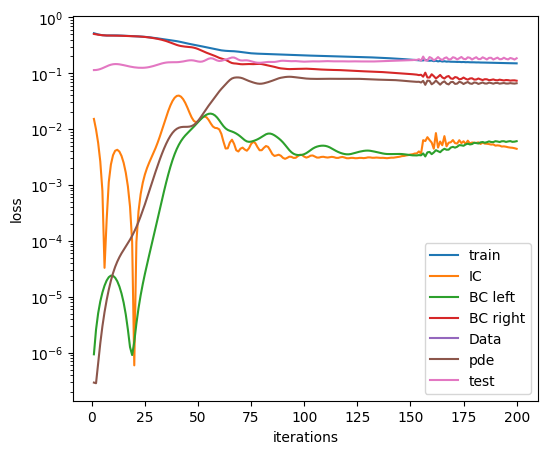

In [7]:
model = PINN(NNdata, layers, diffusivity, 200, 100)
if os.path.isfile('saved/best_model'):
    model.dnn.load_state_dict(torch.load('saved/best_model', map_location=torch.device('cpu')))
else:
    model.train()

**Run the predictions**

Total average error on the prediction w.r.t ground truth = 0.35787175999451204


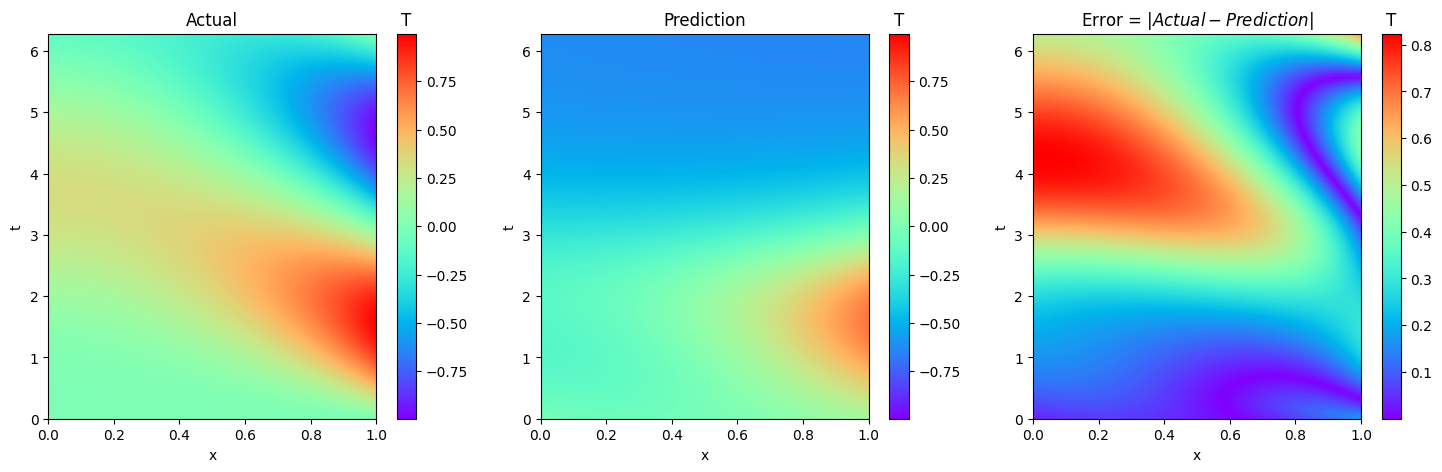

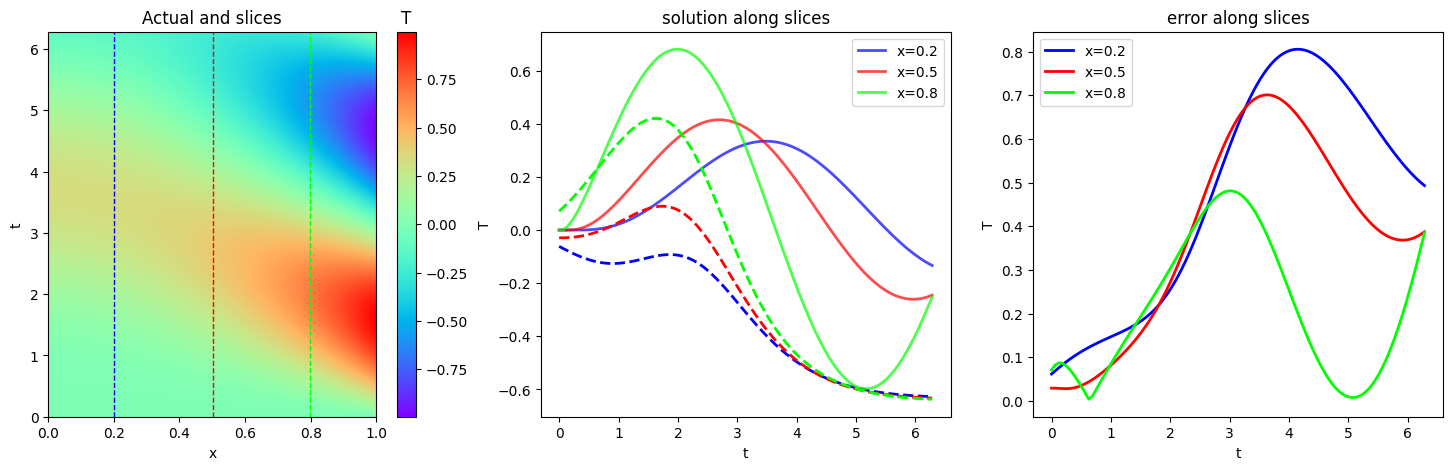

In [8]:
model.predict(NNdata, [0.2, 0.50, 0.8], extent)